## Importando os dados

### Preprocessando nosso texto

##Download do texto

###link do download precisa ser atualizado as vezes, url=http://www.mediafire.com/file/ag4lmha2wqhna72/gu-pt_v1.txt

### Usando a classificação com o tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
path_to_zip = tf.keras.utils.get_file(
    'gu-pt_v1.txt', origin='http://www.mediafire.com/folder/fsm51pinx9xcg/raw_data/gu-pt_v1.txt',
    extract=False)

path_to_file = os.path.dirname(path_to_zip)


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Projetos/IA/raw_data/gu-pt_v1.txt" "gu-pt_v1.txt"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
   
    word_pairs = []
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[1500:1500+num_examples]]
  
    return zip(*word_pairs)

In [6]:
gu, pt = create_dataset('gu-pt_v1.txt', 3)

print(pt[-1])
print(gu[-1])

<start> entao deus disse que haja luz ! e a luz comecou a existir . <end>
<start> ha e gui nhanderuete aipoe i toiko hexakaa he i . ha e ramo hexakaa oiko . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# Try experimenting with the size of that dataset
num_examples = 1500
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('gu-pt_v1.txt', num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(1200, 1200, 300, 300)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [45]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
4 ----> <start>
104 ----> sete
28 ----> foi
29 ----> pai
7 ----> de
21 ----> um
36 ----> filho
3 ----> e
6 ----> o
244 ----> chamou
7 ----> de
889 ----> enos
2 ----> .
28 ----> foi
352 ----> nesse
129 ----> tempo
8 ----> que
6 ----> o
75 ----> nome
24 ----> senhor
262 ----> comecou
9 ----> a
140 ----> ser
1077 ----> usado
37 ----> no
2007 ----> culto
7 ----> de
2008 ----> adoracao
9 ----> a
16 ----> deus
2 ----> .
5 ----> <end>

Target Language; index to word mapping
4 ----> <start>
3 ----> ha
1 ----> e
16 ----> gui
35 ----> petei
27 ----> oiko
50 ----> avi
91 ----> sete
9 ----> ra
13 ----> y
2 ----> .
3 ----> ha
1 ----> e
6 ----> va
1 ----> e
10 ----> ma
110 ----> omboery
642 ----> enos
2 ----> .
3 ----> ha
1 ----> e
6 ----> va
1 ----> e
77 ----> guive
10 ----> ma
40 ----> senhor
156 ----> rery
36 ----> rupi
3 ----> ha
1 ----> e
11 ----> kuery
391 ----> ojapukai
371 ----> ypy
147 ----> raka
1 ----> e
2 ----> .
5 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 95]), TensorShape([64, 94]))

### Write the encoder and decoder model
Implement an encoder-decoder model with attention which you can read about in the TensorFlow Neural Machine Translation (seq2seq) tutorial. This example uses a more recent set of APIs. This notebook implements the attention equations from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from Luong's paper.



In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 95, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 95, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2877)


# Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
def save_epoch_results(part_1, part_2):
  
  file = open('results.txt', 'a')
  file.write(part_1 + " " + part_2)
  
  file.close()
  

In [0]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  
  part_1 = 'Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch) 
  
  part_2 = 'Time {} sec\n'.format(time.time() - start)
  
  save_epoch_results(part_1, part_2)
 
  
  

Epoch 1 Batch 0 Loss 1.0371
Epoch 1 Loss 1.0114
Time taken for 1 epoch 25.84603405 sec

Epoch 2 Batch 0 Loss 1.0016
Epoch 2 Loss 0.9890
Time taken for 1 epoch 27.4740240574 sec

Epoch 3 Batch 0 Loss 0.9818
Epoch 3 Loss 0.9695
Time taken for 1 epoch 26.7449400425 sec

Epoch 4 Batch 0 Loss 0.9685
Epoch 4 Loss 0.9538
Time taken for 1 epoch 27.1792149544 sec

Epoch 5 Batch 0 Loss 0.9438
Epoch 5 Loss 0.9252
Time taken for 1 epoch 26.6321759224 sec

Epoch 6 Batch 0 Loss 0.9269
Epoch 6 Loss 0.8982
Time taken for 1 epoch 27.5003118515 sec

Epoch 7 Batch 0 Loss 0.8811
Epoch 7 Loss 0.8806
Time taken for 1 epoch 26.6773130894 sec

Epoch 8 Batch 0 Loss 0.8706
Epoch 8 Loss 0.8630
Time taken for 1 epoch 27.3789060116 sec

Epoch 9 Batch 0 Loss 0.8616


In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> entao deus disse que haja luz ! e a luz comecou a existir . <end>
Predicted translation: ha e rami vy aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete aipoe i ay ma nhanderuete 


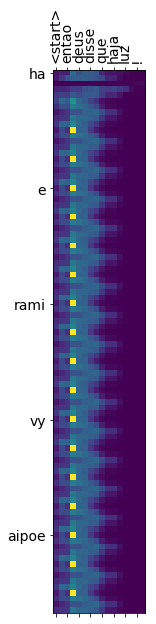

In [30]:
translate('Então Deus disse: —Que haja luz! E a luz começou a existir.')

In [0]:
def load_test_dataset(path, train_size, test_size):
  
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
   
    sentences = []
    original = []
    for line in lines[train_size:train_size+test_size]:
     
      test = line.split('\t')
      original.append(test[0]) 
      sentences.append(test[1]) 
      
    return original, sentences
  

In [0]:
from scipy.spatial import distance

def distance_average(senteces, results):
 
  distances =[]
  for x, y in zip(senteces, results):
    distances.append(distance.hamming(x, y))

  
  return np.mean(distances)

In [0]:
def accuracy(original, sentences):
  
  translation = []
  for sentence in sentences:

    result, sentence, attention_plot = evaluate(sentence)
    translation.append(result)

  all_tensors_x, all_tensors_y = [], []

  for transl, orig in zip(translation, original):

    original_tensor, inp_lang_tokenizer = tokenize(transl)
    translation_tensor, targ_lang_tokenizer = tokenize(orig)

    tensor_x, tensor_y = [], []

    for inp, targ in zip(original_tensor, translation_tensor):
      tensor_x.append(inp[0])
      tensor_y.append(targ[0])
    
    all_tensors_x.append(tensor_x)
    all_tensors_y.append(tensor_y)
    
   
    
    dist = distance_average(all_tensors_x, all_tensors_y)
    
    return 1-dist

In [43]:
original, sentences = load_test_dataset('gu-pt_v1.txt',1200,300)
acc = accuracy(original, sentences)
print(acc)

0.17647058823529416
